In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import random

In [4]:
def factorizer(arr):
    d={}
    c = 0
    for i in arr:
        if i not in d:
            d[i] = c
            c+=1
        else:
            pass
    return d, [d[i] for i in arr]

In [5]:
data = pd.read_csv('All-seasons.csv')[:10000]
data['Line'] = [line.strip() for line in data['Line']]
factors_dict, data['CharFact'] = factorizer(data['Character'])
data.head()

,Season,Episode,Character,Line,CharFact
0,10,1,Stan,"You guys, you guys! Chef is going away.",0
1,10,1,Kyle,Going away? For how long?,1
2,10,1,Stan,Forever.,0
3,10,1,Chef,I'm sorry boys.,2
4,10,1,Stan,"Chef said he's been bored, so he joining a gro...",0


In [6]:
data['Character'].describe()

count       10000
unique        924
top       Cartman
freq         1447
Name: Character, dtype: object

In [7]:
def baseline(data):
    return [random.randint(0, 923) for i in range(len(data))]

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
vectrzr = TfidfVectorizer()
matrix = vectrzr.fit_transform(data['Line'])

Я решила не лемматизировать слова, потому что подумала, что есть возможность, что это несколько сотрёт разницу между репликами различных песонажей. Кроме того, я не использую стоп-слова, потому что у меня тут tf-idf, который и так уже умеет работать со словами разной частотности. Обсценную лексику в стоплист включать, конечно, тоже не надо -- это такая же важная информация о тексте, как и всё остальное.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(matrix, data['CharFact'], test_size=0.2)

In [12]:
from sklearn.metrics import classification_report

In [13]:
print(classification_report(y_train, baseline(y_train)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       693
          1       0.18      0.00      0.01       772
          2       0.00      0.00      0.00        34
          3       0.00      0.00      0.00       110
          4       0.50      0.00      0.01      1163
          5       0.00      0.00      0.00         8
          6       0.00      0.00      0.00        21
          7       0.12      0.01      0.02       108
          8       0.00      0.00      0.00        49
          9       0.00      0.00      0.00         3
         10       0.00      0.00      0.00         1
         11       0.10      0.00      0.01       372
         12       0.00      0.00      0.00         1
         13       0.00      0.00      0.00         1
         14       0.00      0.00      0.00        66
         15       0.00      0.00      0.00         4
         16       0.00      0.00      0.00        53
         17       0.00      0.00      0.00   

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [14]:
from sklearn.metrics import accuracy_score

In [15]:
accuracy_score(y_train, baseline(y_train))

0.00125

In [16]:
len(y_train)

8000

Как видно, baseline вообще практически ничего не угадывает, оно и неудивительно: у нас 924 класса и 8000 сэмплов.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [18]:
parameters = {'C': [1, 10, 100, 1000], 'fit_intercept': [False, True], 'solver': ['newton-cg', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']}

In [ ]:
logit2 = LogisticRegression()
logit2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
logit = LogisticRegression()
clf_logit = GridSearchCV(logit, parameters, verbose=2)
clf_logit.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


[CV] fit_intercept=False, multi_class=ovr, solver=newton-cg, C=1 .....
[CV]  fit_intercept=False, multi_class=ovr, solver=newton-cg, C=1, total=  35.5s
[CV] fit_intercept=False, multi_class=ovr, solver=newton-cg, C=1 .....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.6s remaining:    0.0s


[CV]  fit_intercept=False, multi_class=ovr, solver=newton-cg, C=1, total= 1.2min
[CV] fit_intercept=False, multi_class=ovr, solver=newton-cg, C=1 .....
[CV]  fit_intercept=False, multi_class=ovr, solver=newton-cg, C=1, total= 1.1min
[CV] fit_intercept=False, multi_class=ovr, solver=lbfgs, C=1 .........
[CV]  fit_intercept=False, multi_class=ovr, solver=lbfgs, C=1, total=  22.3s
[CV] fit_intercept=False, multi_class=ovr, solver=lbfgs, C=1 .........
[CV]  fit_intercept=False, multi_class=ovr, solver=lbfgs, C=1, total= 1.1min
[CV] fit_intercept=False, multi_class=ovr, solver=lbfgs, C=1 .........
[CV]  fit_intercept=False, multi_class=ovr, solver=lbfgs, C=1, total=  39.2s
[CV] fit_intercept=False, multi_class=multinomial, solver=newton-cg, C=1 
[CV]  fit_intercept=False, multi_class=multinomial, solver=newton-cg, C=1, total=  59.8s
[CV] fit_intercept=False, multi_class=multinomial, solver=newton-cg, C=1 
[CV]  fit_intercept=False, multi_class=multinomial, solver=newton-cg, C=1, total= 1.5m

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 449.6min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'fit_intercept': [False, True], 'solver': ['newton-cg', 'lbfgs'], 'multi_class': ['ovr', 'multinomial'], 'C': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [28]:
print(classification_report(logit.predict(X_train), y_train))

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


             precision    recall  f1-score   support

          0       0.79      0.63      0.70       898
          1       0.81      0.67      0.73       945
          2       0.84      0.94      0.89        33
          3       0.80      0.86      0.83       107
          4       0.91      0.75      0.82      1381
          5       1.00      1.00      1.00        10
          6       0.80      0.95      0.87        21
          7       0.80      0.93      0.86        81
          8       0.92      0.96      0.94        46
          9       0.50      1.00      0.67         1
         10       0.00      0.00      0.00         0
         11       0.82      0.86      0.84       337
         12       0.00      0.00      0.00         0
         13       1.00      1.00      1.00         1
         14       0.73      0.82      0.77        55
         15       0.00      0.00      0.00         0
         16       0.55      0.88      0.67        32
         17       0.33      0.67      0.44   

In [25]:
clf_logit.best_params_

{'C': 10,
 'fit_intercept': True,
 'multi_class': 'multinomial',
 'solver': 'lbfgs'}

In [19]:
logit = LogisticRegression(C=10, fit_intercept=True, multi_class='multinomial', solver='lbfgs')
logit.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [20]:
logit.intercept_

array([  4.94112104e+00,   5.21664048e+00,   2.59637623e+00,
         2.36813809e+00,   5.01417785e+00,   1.08934928e+00,
         1.55975498e+00,   2.60066780e+00,   1.95614582e+00,
         2.00761749e-01,  -7.21731895e-01,   4.13895247e+00,
        -1.14184084e+00,  -7.70742200e-01,   2.60555420e+00,
         4.38760261e-01,   2.44629118e+00,   1.66041571e+00,
         7.18521103e-01,   4.44082607e+00,  -1.32230280e+00,
         9.36259978e-01,   9.80826270e-02,   1.74824301e+00,
        -1.05473817e-01,   2.24005924e+00,   8.59023451e-01,
         1.12208480e+00,  -2.75785645e-01,  -5.40885336e-01,
        -6.97440125e-01,   1.26303869e-01,  -5.62864294e-03,
        -6.90315365e-01,   6.66518813e-01,   2.21654742e+00,
         1.27493656e+00,   2.15396230e+00,   1.49788869e+00,
         2.56938371e+00,   2.38605859e+00,   2.05970809e+00,
         1.48129285e+00,   1.68443613e+00,   2.31406905e-01,
        -1.13645409e+00,  -9.52767206e-01,  -8.77284209e-01,
        -9.79383664e-01,

Это, кажется, свободные коэффициенты для каждого из классов, которые решают, относится ли объект к классу, когда все остальные признаки равны нулю.

In [21]:
logit.coef_

array([[ -6.27333690e-02,   1.32967556e+00,  -9.40501749e-01, ...,
         -2.92104568e-01,  -2.54650052e-01,   0.00000000e+00],
       [ -1.02577435e-01,  -1.62698672e-01,  -6.09527268e-01, ...,
         -3.15304368e-01,   2.49047886e+00,   0.00000000e+00],
       [ -5.06107354e-03,  -8.23107447e-03,  -3.26768496e-02, ...,
         -5.63385669e-02,  -1.55380399e-02,   0.00000000e+00],
       ..., 
       [ -1.89181502e-03,  -2.75647046e-03,  -1.50421146e-02, ...,
         -1.05895162e-02,  -3.27266090e-03,   0.00000000e+00],
       [ -9.29503371e-04,  -1.21359655e-03,  -8.26981625e-03, ...,
         -5.46317995e-03,  -1.77649873e-03,   0.00000000e+00],
       [ -2.48819746e-04,  -3.83205838e-04,  -2.11394927e-03, ...,
         -1.47016897e-03,  -4.32468688e-04,   0.00000000e+00]])

Это матрица коэффициентов регрессии, тут для каждого класса показано, как каждая фича на него влияет. Если коэф. положительный, то вероятность отнесения элемента с такой фичей к этому классу увеличивается, если отрицательный, то уменьшается. Присваивается тот класс, вероятность которого оказывается в итоге выше всего.

In [22]:
from sklearn.ensemble import RandomForestClassifier
forest_params = {'max_features':[.25, .3, .5, 'sqrt', 'log2', None], 'max_depth':[10, 100, 1000, 10000, None], 'bootstrap':[True, False]}

In [20]:
clf_forest = GridSearchCV(RandomForestClassifier(), forest_params, verbose=10)
clf_forest.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


[CV] bootstrap=True, max_depth=10, max_features=0.25 .................
[CV]  bootstrap=True, max_depth=10, max_features=0.25, score=0.150196, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=0.25 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=0.25, score=0.175540, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=0.25 .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=0.25, score=0.200255, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=0.3 ..................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=0.3, score=0.152487, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=0.3 ..................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.4s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=0.3, score=0.179784, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=0.3 ..................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.7s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=0.3, score=0.194728, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=0.5 ..................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   21.2s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=0.5, score=0.154123, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=0.5 ..................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   25.1s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=0.5, score=0.177855, total=   6.5s
[CV] bootstrap=True, max_depth=10, max_features=0.5 ..................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   32.2s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=0.5, score=0.202381, total=   6.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt .................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   38.9s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=sqrt, score=0.138743, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt .................
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, score=0.161265, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=sqrt .................
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, score=0.180272, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2 .................
[CV]  bootstrap=True, max_depth=10, max_features=log2, score=0.127291, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2 .................
[CV]  bootstrap=True, max_depth=10, max_features=log2, score=0.150077, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2 .................
[CV]  bootstrap=True, max_depth=10, max_features=log2, score=0.162840, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=None .................
[CV]  bootstrap=True, max_depth=10, max_features=None, score=0.1

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 128.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [10, 100, 1000, 10000, None], 'bootstrap': [True, False], 'max_features': [0.25, 0.3, 0.5, 'sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [21]:
clf_forest.best_params_

{'bootstrap': True, 'max_depth': 1000, 'max_features': 0.25}

In [23]:
clf_forest = RandomForestClassifier(bootstrap=True, max_depth=1000, max_features=0.25)
clf_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1000, max_features=0.25, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Здесь и далее: я делаю гридсерч, а потом создаю новый классификатор с подобранными параметрами не потому что мне нравится делать двойную работу, а потому что гридсерч долго обучается, а код иногда приходится перезапускать с нуля.

In [24]:
print(classification_report(clf_forest.predict(X_train), y_train))

             precision    recall  f1-score   support

          0       0.91      0.83      0.87       758
          1       0.92      0.81      0.86       877
          2       0.85      0.97      0.91        30
          3       0.95      0.90      0.92       115
          4       0.95      0.93      0.94      1196
          5       1.00      1.00      1.00         8
          6       0.90      1.00      0.95        19
          7       0.93      0.98      0.95       102
          8       0.92      1.00      0.96        45
          9       1.00      1.00      1.00         3
         10       1.00      1.00      1.00         1
         11       0.92      0.95      0.94       362
         12       1.00      1.00      1.00         1
         13       1.00      1.00      1.00         1
         14       0.85      0.84      0.84        67
         15       1.00      1.00      1.00         4
         16       0.85      0.96      0.90        47
         17       0.64      0.64      0.64   

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [25]:
from sklearn.naive_bayes import MultinomialNB
bayes_params = {'alpha':[0.0, .1, .25, .3, .5, .75, .9, 1.0], 'fit_prior':[True, False]}

In [26]:
clf_bayes = MultinomialNB(alpha=0.00000001, fit_prior=False)
clf_bayes.fit(X_train, y_train)

MultinomialNB(alpha=1e-08, class_prior=None, fit_prior=False)

GridSearch применить не удалось, параметры подбирались вручную.

In [27]:
print(classification_report(clf_bayes.predict(X_train), y_train))

             precision    recall  f1-score   support

          0       0.55      0.85      0.66       444
          1       0.53      0.87      0.66       468
          2       0.65      0.85      0.73        26
          3       0.78      0.87      0.82        99
          4       0.68      0.97      0.80       812
          5       1.00      0.73      0.84        11
          6       0.81      0.68      0.74        25
          7       0.79      0.77      0.78       111
          8       0.82      0.82      0.82        49
          9       1.00      0.75      0.86         4
         10       1.00      0.14      0.25         7
         11       0.69      0.90      0.78       283
         12       1.00      1.00      1.00         1
         13       1.00      1.00      1.00         1
         14       0.55      0.56      0.55        64
         15       1.00      0.67      0.80         6
         16       0.62      0.65      0.63        51
         17       0.50      0.78      0.61   

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Как видно, лучшей моделью у нас оказался лес с максимальной глубиной дерева 1000, максимальным количеством фич для разбиения выборки на 2 части -- 25% от общего кол-ва фич, и с бутстрэппингом (я так и не поняла, что это).

***Финальная битва на тестовых данных***

In [28]:
print(classification_report(logit.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.37      0.20      0.26       345
          1       0.43      0.19      0.26       455
          2       0.25      0.50      0.33         6
          3       0.21      0.33      0.26        21
          4       0.61      0.29      0.39       596
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         1
          7       0.05      0.06      0.05        17
          8       0.50      0.55      0.52        11
         11       0.42      0.24      0.31       128
         14       0.06      0.17      0.09         6
         16       0.00      0.00      0.00         8
         17       0.00      0.00      0.00         1
         19       0.33      0.22      0.26       117
         21       0.00      0.00      0.00         0
         23       0.00      0.00      0.00         0
         24       0.00      0.00      0.00         0
         26       0.00      0.00      0.00   

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [29]:
print(classification_report(clf_forest.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.31      0.17      0.22       350
          1       0.32      0.16      0.22       383
          2       0.33      0.50      0.40         8
          3       0.15      0.19      0.17        27
          4       0.53      0.26      0.35       571
          5       0.00      0.00      0.00         0
          6       0.09      0.33      0.14         3
          7       0.10      0.12      0.11        17
          8       0.67      0.62      0.64        13
         11       0.23      0.17      0.20        99
         14       0.06      0.14      0.09         7
         16       0.00      0.00      0.00         2
         17       0.20      0.20      0.20         5
         18       0.00      0.00      0.00         1
         19       0.23      0.25      0.24        73
         21       0.00      0.00      0.00         0
         23       0.00      0.00      0.00         0
         24       0.33      0.20      0.25   

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [30]:
print(classification_report(clf_bayes.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.24      0.22      0.23       204
          1       0.20      0.20      0.20       191
          2       0.17      0.50      0.25         4
          3       0.03      0.02      0.02        48
          4       0.43      0.30      0.35       411
          5       0.00      0.00      0.00         1
          6       0.00      0.00      0.00         3
          7       0.05      0.04      0.04        25
          8       0.25      0.16      0.19        19
          9       0.00      0.00      0.00         1
         10       0.00      0.00      0.00         2
         11       0.31      0.25      0.28        92
         14       0.06      0.08      0.07        12
         16       0.11      0.07      0.08        15
         17       0.00      0.00      0.00         1
         18       0.00      0.00      0.00         2
         19       0.20      0.23      0.21        69
         20       0.00      0.00      0.00   

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


На тестовой выборке логистическая регрессия справилась лучше всего, но вообще результаты не очень впечатляют. Хотя вообще это не очень удивительно, если учесть, что у нас очень много персонажей (и большинство -- второстепенные), и для каждого объекта выборки надо угадывать, какому персонажу принадлежит реплика, по очень маленькому количеству слов.

In [31]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [32]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=100)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

[learning_curve] Training set sizes: [ 800 2600 4400 6200 8000]
[CV]  ................................................................
[CV] ................................. , score=0.161000, total= 1.1min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[CV]  ................................................................
[CV] ................................. , score=0.183500, total= 2.7min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s
[CV]  ................................................................
[CV] ................................. , score=0.204000, total= 3.6min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.4min remaining:    0.0s
[CV]  ................................................................
[CV] ................................. , score=0.221000, total= 4.7min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 12.2min remaining:    0.0s
[CV]  ..........................................

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

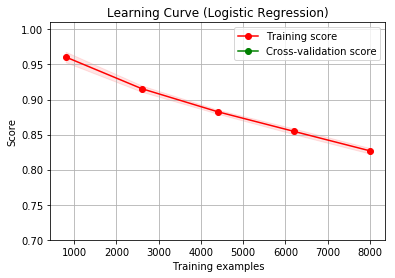

In [33]:
title = "Learning Curve (Logistic Regression)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = logit
plot_learning_curve(estimator, title, matrix, data['CharFact'], ylim=(0.7, 1.01), cv=cv, n_jobs=1)

Всё очень плохо.